**Kaggle "Titanic: Machine Learning from Disaster".**

In [2]:
# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
%pylab inline
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression

Populating the interactive namespace from numpy and matplotlib


In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/agconti/kaggle-titanic/master/data/train.csv",index_col='PassengerId')  

URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

In [ ]:
df=df.drop(['Ticket','Cabin','Embarked','Name'],axis=1)

In [ ]:
holdout = df.sample(100) # рандомная отложенная часть
df = df.loc[~df.index.isin(holdout.index)] #наш датасет без отложенной части

In [ ]:
y_h.value_counts(normalize=True)

In [ ]:
y_train.value_counts(normalize=True)

In [ ]:
#целевое событие
y = df.Survived

In [ ]:
#датасет без целевого события
df= df.drop(['Survived'],axis=1)

In [ ]:
df.head()

**ЗАДАНИЕ**

1) Разбейте данные на train и test (пропорция 80/20, укажите в параметрах random_state = 17 и stratify = y)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=17, test_size=0.2, stratify=y)

In [52]:
y_test.value_counts()

0    99
1    60
Name: Survived, dtype: int64

**Вопрос 1: Сколько выживших людей попало в test часть?** 

2) Примените к обеим частям выборки пайплайн vec(задан ниже) 

In [53]:
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction import DictVectorizer

def get_categ_col(df):
    return df[['Sex','Pclass']]

def get_num_cols(df):
    return df[['Age', 'Fare', 'SibSp', 'Parch']]

vec = make_union(*[
   make_pipeline(FunctionTransformer(get_categ_col, validate=False),  OneHotEncoder(sparse=False)),
   make_pipeline(FunctionTransformer(get_num_cols, validate=False), SimpleImputer(strategy='median'), StandardScaler()),
])

In [ ]:
X_train [10,10,10,10,40,50,60, null...20% ]
[-1....0...1]

In [ ]:
X_test [10,30,40  null...20%]
[-1....0...1]

In [54]:
ohe = OneHotEncoder()
ohe.fit(get_categ_col(df))
ohe.get_feature_names()

array(['x0_female', 'x0_male', 'x1_1', 'x1_2', 'x1_3'], dtype=object)

**Вопрос 2: Сколько колонок получилось в train выборке после применения пайплайна?** 

In [55]:
vec.fit_transform(X_train).shape

(632, 9)

In [56]:
X_train = vec.fit_transform(X_train)
X_test = vec.transform(X_test)

In [121]:
X_test[0]

array([ 0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
       -0.78547256, -0.48561961, -0.47355916, -0.4825497 ])

3) С помощью GridSearchCV обучите модель LogisticRegression: сбалансируйте классы, переберите значения параметра С [0.01, 0.05, 0.1, 0.5, 1, 5, 10], задайте 3 фолда на кроссвалидации

Посчитайте средний roc_auc на тестовых фолдах.

In [126]:
reg = LogisticRegression()
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=5)
grid = {'C':  [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
cv = GridSearchCV(reg, param_grid=grid, cv=skf, scoring="roc_auc")
cv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=5, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]},
             scoring='roc_auc')

In [127]:
cv.best_score_

0.8433957167578773

**Вопрос 3: Чему равен средний roc_auc?**

In [58]:
cv.cv_results_

{'mean_fit_time': array([0.01123261, 0.01211031, 0.01550635, 0.01622136, 0.01557779,
        0.02835814, 0.02280172]),
 'std_fit_time': array([0.00195165, 0.00010031, 0.00247598, 0.00236623, 0.00209111,
        0.0099666 , 0.00239951]),
 'mean_score_time': array([0.0031871 , 0.00302831, 0.00287604, 0.00309507, 0.00303149,
        0.00335622, 0.00324464]),
 'std_score_time': array([0.00085906, 0.00059842, 0.00062597, 0.00034031, 0.00017159,
        0.00058881, 0.00014745]),
 'param_C': masked_array(data=[0.01, 0.05, 0.1, 0.5, 1, 5, 10],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.01},
  {'C': 0.05},
  {'C': 0.1},
  {'C': 0.5},
  {'C': 1},
  {'C': 5},
  {'C': 10}],
 'split0_test_score': array([0.83103184, 0.84119678, 0.84455313, 0.84714231, 0.84714231,
        0.8473341 , 0.8472382 ]),
 'split1_test_score': array([0.81889313, 0.81564885, 0.81459924, 0.81383588, 0.8134542 ,
        0.81288168

In [101]:
np.mean([0.84455313, 0.81459924, 0.87114697])

0.8434331133333334

In [60]:
cv.best_score_

0.8434331111872421

In [87]:
cv.best_params_

{'C': 0.1}

**Вопрос 4: Чему равен roc_auc для holdout?**

In [61]:
y_h = holdout['Survived']

In [62]:
holdout = vec.transform(holdout.drop(['Survived'],axis=1))

In [1]:
from sklearn.metrics import roc_auc_score

In [146]:
roc_auc_score(cv.predict_proba(holdout),y_h.values)

ValueError: continuous-multioutput format is not supported

In [65]:
roc_auc_score(cv.best_estimator_.predict_proba(X_test),y_test)

0.8120219487861657

**Вопрос 5: Какая доля влияния Pclass в итоговой модели?**

In [66]:
cv.best_estimator_.coef_[0]

array([ 1.0205771 , -1.02056976,  0.61390015,  0.07528156, -0.68917437,
       -0.41590709,  0.29911594, -0.30424416, -0.02486063])

In [67]:
np.exp(cv.best_estimator_.coef_)

array([[2.77479565, 0.36038954, 1.84762337, 1.07818769, 0.50199036,
        0.65974156, 1.34866598, 0.73768073, 0.97544585]])

In [68]:
(np.exp(cv.best_estimator_.coef_[0][2])/np.exp(cv.best_estimator_.coef_).sum())

0.17965089662812955

In [69]:
(np.exp(cv.best_estimator_.coef_[0][3])/np.exp(cv.best_estimator_.coef_).sum())

0.10483596801124467

In [70]:
(np.exp(cv.best_estimator_.coef_[0][4])/np.exp(cv.best_estimator_.coef_).sum())

0.048810281896062735

6) Теперь попробуйте применить к тем же данным дерево решений. 
Переберите значения для 5 разных параметров дерева решений (глубина, число листьев и т.д.) с помощью RandomizedSearch(n_iter = 100). Посчитайте roc_auc

In [103]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

tree_params = {'max_depth':range(2,11),
              'min_samples_leaf':range(2,6),
              'min_samples_split':range(2,11),
              'max_features':[0.7,0.8,0.9,1]
              } 

dtree = RandomizedSearchCV(DecisionTreeClassifier(random_state=42),
                                 tree_params, n_iter=10, cv=skf, n_jobs=-1)


In [104]:
dtree.fit(X_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=5, shuffle=True),
                   estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
                   param_distributions={'max_depth': range(2, 11),
                                        'max_features': [0.7, 0.8, 0.9, 1],
                                        'min_samples_leaf': range(2, 6),
                                        'min_samples_split': range(2, 11)})

In [105]:
dtree.best_params_

{'min_samples_split': 7,
 'min_samples_leaf': 5,
 'max_features': 0.8,
 'max_depth': 3}

In [ ]:
{'max_depth': 5,
 'max_features': 0.9,
 'min_samples_leaf': 5,
 'min_samples_split': 6}

In [106]:
dtree.best_score_

0.8212442638982923

In [140]:
tree_params = {'max_depth':range(2,6),
              'min_samples_leaf':range(5,7),
              'min_samples_split':range(6,9),
              'max_features':[0.7,0.8,0.9]
              } 

dtree = GridSearchCV(DecisionTreeClassifier(random_state=42),
                                 tree_params, cv=skf, n_jobs=-1,verbose=1)


dtree.fit(X_train,y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=5, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(3, 6),
                         'max_features': [0.7, 0.8, 0.9],
                         'min_samples_leaf': range(5, 7),
                         'min_samples_split': range(6, 9)},
             verbose=1)

In [141]:
dtree.best_params_

{'max_depth': 5,
 'max_features': 0.9,
 'min_samples_leaf': 5,
 'min_samples_split': 6}

In [142]:
dtree.best_score_

0.835477318889641

In [143]:
roc_auc_score(dtree.best_estimator_.predict(X_test),y_test)

0.8722222222222222

In [144]:
roc_auc_score(dtree.best_estimator_.predict(holdout),y_h)

0.7571428571428572

7) Возьмите лучшее дерево из п.6 и визуализируйте его с помощью graphviz 

In [78]:
X_train

array([[ 0.        ,  1.        ,  0.        , ..., -0.3844464 ,
        -0.47355916, -0.4825497 ],
       [ 1.        ,  0.        ,  1.        , ...,  0.79201055,
        -0.47355916, -0.4825497 ],
       [ 0.        ,  1.        ,  0.        , ..., -0.48657665,
        -0.47355916, -0.4825497 ],
       ...,
       [ 0.        ,  1.        ,  0.        , ..., -0.49049469,
        -0.47355916, -0.4825497 ],
       [ 0.        ,  1.        ,  1.        , ...,  1.71092164,
        -0.47355916,  1.9378583 ],
       [ 1.        ,  0.        ,  1.        , ...,  1.08159657,
        -0.47355916,  0.7276543 ]])

In [79]:
#conda install graphviz

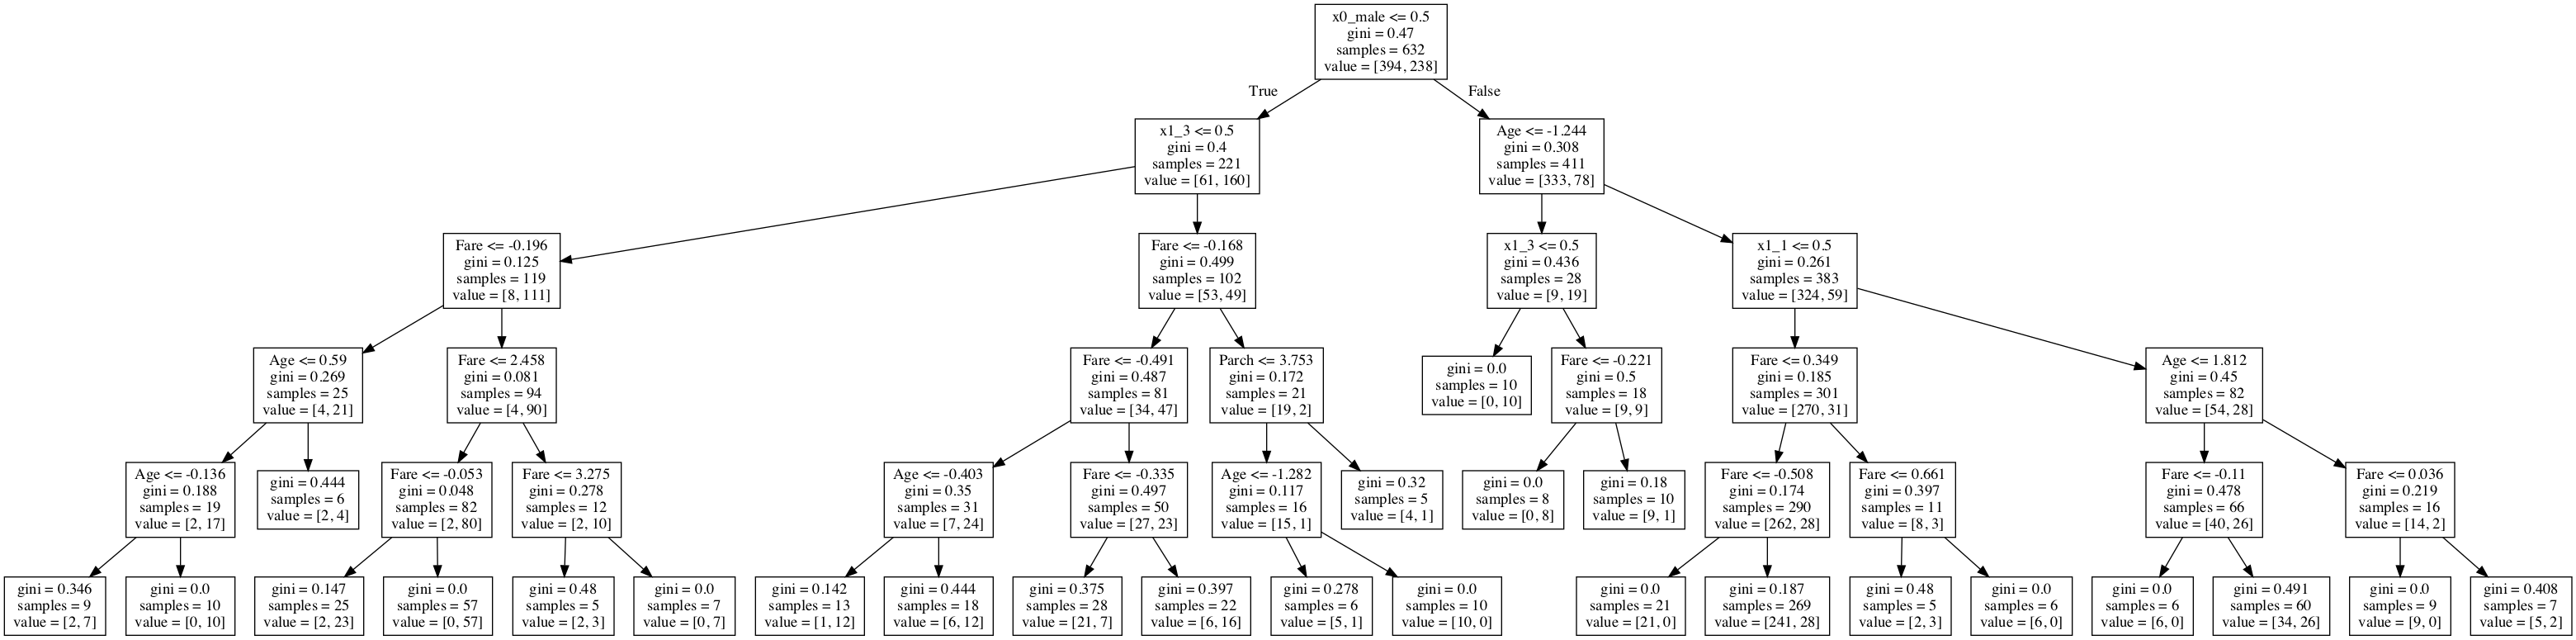

In [110]:
import sklearn
from graphviz import Source
graph = Source(sklearn.tree.export_graphviz(dtree.best_estimator_, out_file=None, feature_names=['x0_female', 'x0_male', 'x1_1', 'x1_2', 'x1_3','Age', 'Fare', 'SibSp', 'Parch']))
png_bytes = graph.pipe(format='png')
with open('dtree1_pipe.png','wb') as f:
    f.write(png_bytes)

from IPython.display import Image
Image(png_bytes)

8) Запустите в цикле обучение дерева решений для X_train с разными значениями max_depth от 1 до 10. 
Нарисуйте график как меняется roc auc в зависимости от max_depth для выборок X_train и X_test, сравните насколько графики похожи.

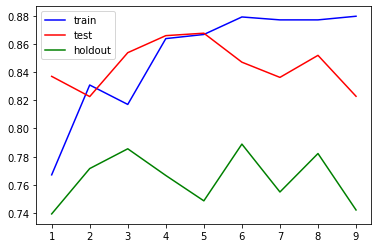

In [111]:
from sklearn.model_selection import cross_val_score
max_depth = range(1, 10)
errors_train = []
errors_test = []
errors_holdout = []

for k in max_depth:
    dtree = DecisionTreeClassifier(max_depth=k, max_features= 0.9,min_samples_leaf= 5,min_samples_split= 6, random_state=17)
    dtree.fit(X_train, y_train)
    errors_train.append(roc_auc_score(dtree.predict(X_train),y_train))
    errors_test.append(roc_auc_score(dtree.predict(X_test), y_test))
    errors_holdout.append(roc_auc_score(dtree.predict(holdout), y_h))
    
plt.plot(max_depth, errors_train, color='blue', label='train')
plt.plot(max_depth, errors_test, color='red', label='test')
plt.plot(max_depth, errors_holdout, color='green', label='holdout')
plt.legend()


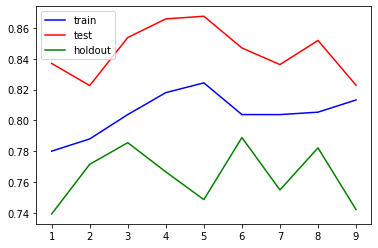

In [112]:
from sklearn.model_selection import cross_val_score
max_depth = range(1, 10)
errors_train = []
errors_test = []
errors_holdout = []

for k in max_depth:
    dtree = DecisionTreeClassifier(max_depth=k, max_features= 0.9,min_samples_leaf= 5,min_samples_split= 6,random_state=17)
    errors_train.append(cross_val_score(dtree,X_train,y_train, cv=skf).mean())
    dtree.fit(X_train, y_train)
    errors_test.append(roc_auc_score(dtree.predict_proba(X_test), y_test))
    errors_holdout.append(roc_auc_score(dtree.predict_proba(holdout), y_h))
    
plt.plot(max_depth, errors_train, color='blue', label='train')
plt.plot(max_depth, errors_test, color='red', label='test')
plt.plot(max_depth, errors_holdout, color='green', label='holdout')
plt.legend()


In [115]:
from sklearn.linear_model import LogisticRegressionCV

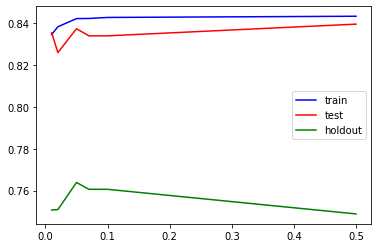

In [130]:
C = [0.01, 0.02, 0.05, 0.07, 0.1, 0.5]
errors_train = []
errors_test = []
errors_holdout = []

for k in C:
    logreg = LogisticRegressionCV(Cs = [k], cv =skf, scoring = 'roc_auc')
    errors_train.append(cross_val_score(logreg,X_train,y_train, cv=skf).mean())
    logreg.fit(X_train, y_train)
    errors_test.append(roc_auc_score(logreg.predict(X_test), y_test))
    errors_holdout.append(roc_auc_score(logreg.predict(holdout), y_h))
    
plt.plot(C, errors_train, color='blue', label='train')
plt.plot(C, errors_test, color='red', label='test')
plt.plot(C, errors_holdout, color='green', label='holdout')
plt.legend()


In [133]:
logreg

LogisticRegressionCV(Cs=[0.5],
                     cv=StratifiedKFold(n_splits=3, random_state=5, shuffle=True),
                     scoring='roc_auc')

In [148]:
cross_val_score(logreg,X_train,y_train, cv=skf).mean()

0.8433957167578773

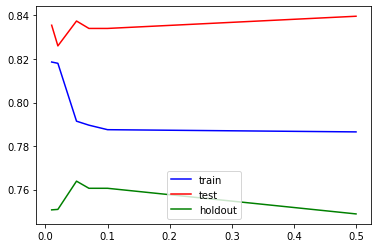

In [129]:
C = [0.01, 0.02, 0.05, 0.07, 0.1, 0.5]
errors_train = []
errors_test = []
errors_holdout = []

for k in C:
    logreg = LogisticRegression(C = k)
    #errors_train.append(cross_val_score(logreg,X_train,y_train, cv=skf).mean())
    logreg.fit(X_train, y_train)
    errors_train.append(roc_auc_score(logreg.predict(X_train), y_train))
    errors_test.append(roc_auc_score(logreg.predict(X_test), y_test))
    errors_holdout.append(roc_auc_score(logreg.predict(holdout), y_h))
    
plt.plot(C, errors_train, color='blue', label='train')
plt.plot(C, errors_test, color='red', label='test')
plt.plot(C, errors_holdout, color='green', label='holdout')
plt.legend()
